# <font color="gren">**Exercício 7**

## **1-Imports Necessários**

In [194]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.interpolate import interp1d
from scipy import sparse
import math

## **2-Definição da rede**


### Função de definição da rede

In [195]:
def GeraRede(nx,ny,CH,CV):
    nv = nx*ny
    nc = (nx-1)*ny + (ny-1)*nx
    
    conec = np.zeros(shape=(nc,2),dtype=np.int64)
    C = np.zeros(nc)
    
    # Loop sobre canos horizontais
    for j in range(ny):
        for i in range(nx-1):
          k = j*(nx-1) + i
          conec[k,0] = j*nx + i
          conec[k,1] = j*nx + i+1
          C[k] = CH

    # Loop sobre canos verticais
    for i in range(nx):
      for j in range(ny-1):
          k = (nx-1)*ny + j*nx + i
          conec[k,0] = i + j*nx
          conec[k,1] = i + (j+1)*nx
          C[k] = CV

    return nv, nc, conec, C

## **3-Funções de resolução da rede**

### 1- Monta matriz conduc e matriz A

In [196]:
def retorna_conduc(C):
    tam=len(C)
    conduc=np.zeros(shape=(tam,tam),dtype=np.float64)
    for i in range(tam):
        conduc[i][i]=C[i]
    return conduc


def retorna_matriz_A(conec,nc,nv,conduc):
    #Inicia a matriz A que será retornada
    A=np.zeros(shape=(nv,nv),dtype=np.float64)
    
    n1,n2=0,0

    for i in range(nc): # percorre as linhas da matriz de conecções
        
        #recebimento dos nós da linha i da matriz de conecções
        n1,n2=conec[i][0],conec[i][1]

        # adição de elementos conforme a matriz ClocK
        A[n1][n1]=A[n1][n1]+conduc[i][i]    
        A[n1][n2]=A[n1][n2]-conduc[i][i]
        A[n2][n1]=A[n2][n1]-conduc[i][i]
        A[n2][n2]=A[n2][n2]+conduc[i][i]
                        
    
    return A

### 2-Função de formação da matriz Ã e matriz direita

In [197]:

def retorna_matriz_Ã(A,natm):
    rng=len(A[0])
    Ã=A
    for i in range(0,rng):
        if(i==natm):
            Ã[natm][i]=1
        else:
            Ã[natm][i]=0
    return Ã

def retorna_matriz_direita(nv,nB,QB):
    d=np.zeros(nv,dtype=np.float64)
    for i in range(0,nv):
        if(i==nB): d[i]=QB
        else: d[i]=0
    return d



### 3-Função de resolução do sistema e de vazões nodais

In [198]:
def retorna_pressoes(Ã,d):
    #Obtém a matriz exparsa da matriz Ã
    Ã_aux = scipy.sparse.csr_matrix(Ã)

    #Obtém vetor de pressões
    P = sparse.linalg.spsolve(Ã_aux, d)
    return P

def vetor_vazoes_nodos(A,P):
    Q=A@P
    return Q

### 4-Obtenção do vetor de vazões nos canos e da potência da bomba

In [199]:
def retorna_potencia(conduc,D,P):
    Qc=conduc@D@P
    W=(Qc.transpose())@(D@P)
    return W

### 5-Obtenção da matriz D(diferenças)

In [200]:
def retorna_matriz_D(nv,nc,conec):
    l=nc
    c=nv
    D=np.zeros(shape=(l,c),dtype=np.float64)
    for i in range(l):
        n1,n2=conec[i][0],conec[i][1]
        D[i][n1]=1
        D[i][n2]=-1
    return D

### 6-Resolve o sistema

In [201]:
def resolve_sistema(natm,nB,QB,nv,nc,conec,conduc):
    A=retorna_matriz_A(conec,nc,nv,conduc)
    Ã=retorna_matriz_Ã(A,natm)
    d=retorna_matriz_direita(nv,nB,QB)
    P=retorna_pressoes(Ã,d)
    return P
   

### 7-Retorno da potência dissipada em função dos valores variáveis de CH e CV

In [202]:
def potencia_dissipada(nx,ny,nB,QB,natm,CH,CV):
    nv, nc, conec, C = GeraRede(nx,ny,CH,CV)
    conduc=retorna_conduc(C)
    P=resolve_sistema(natm,nB,QB,nv,nc,conec,conduc)
    D=retorna_matriz_D(nv,nc,conec)
    return retorna_potencia(conduc,D,P)  
    

## **4-Definição da função $f(x)$ a calcularmos a derivada**


### *OBS: nesse caso deve ser igual a potência dissipado para um valor x*

In [203]:
def f(x):
    #   Pré-setagem
    n=8
    m=9
    natm=m*n - 1
    nB=0
    QB=3

    #   Conductâncias dos canos em função de x
    CH=2.3+10*np.exp(-((x-5)**2))
    CV=1.8+10*np.exp(-((x-5)**2))

    #   Retorna potência dissipada para um dado valor x
    return(potencia_dissipada(n,m,nB,QB,natm,CH,CV)) ##iremos integrar a própria potência

## **5-Definição da função que calcula $f'(x)$**
*(derivação central)*

### a)Diferrença finita adiantada

In [204]:
def deriv_f_ffd(a,b,N,f,x):
    h=(b-a)/N #calcula tamanho da diferença h

    return ((f(x+h) - f(x))/h)

### b)Diferença finita atrasada

In [205]:
def deriv_f_bfd(a,b,N,f,x):
    h=(b-a)/N #calcula tamanho da diferença h
    
    return ((f(x) - f(x-h))/h)

### c)Diferença finita centrada

In [206]:
def deriv_f_cfd(a,b,N,f,x):
    h=(b-a)/N #calcula tamanho da diferença h

    return ((f(x+h) - f(x-h))/(2*h))

## **6-Obtenção dos valores de potência usando funções da rede**

In [207]:
#   Pré-setagem
n=8
m=9
natm=m*n - 1
nB=0
QB=3

#   Vetor x
lenx=100
x=np.linspace(1,10,lenx)

#   Obtenção do vetor de potências
deriv_pont=np.array([])
for i in range (lenx):
    CH=2.3+10*np.exp(-((x[i]-5)**2))
    CV=1.8+10*np.exp(-((x[i]-5)**2))
    deriv_pont=np.append(deriv_pont,potencia_dissipada(n,m,nB,QB,natm,CH,CV))

### Plotagem

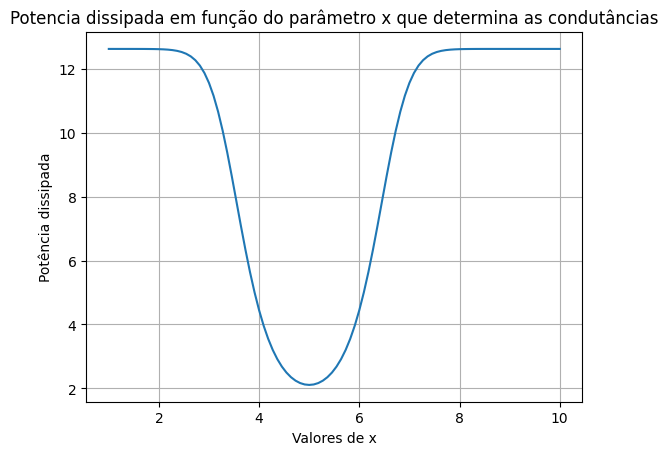

In [208]:
plt.plot(x,deriv_pont)
plt.grid()
plt.xlabel('Valores de x')
plt.ylabel('Potência dissipada')
plt.title('Potencia dissipada em função do parâmetro x que determina as condutâncias')
plt.show()

## **7-Obtenção de resultados usando cálculo de derivada**

In [209]:
#   Pŕe-set do número N de subintervalos no domínio [a,b] no qual a função f está definida
N=100

#   Vetor de valores de x a serem considerados
lenx=100
x=np.linspace(1,10,lenx)

#Vetores de derivadas de potência:
#a)Usando diferença finita adiantada
deriv_pont_ffd=np.zeros(lenx)
for i in range (0,lenx):
    deriv_pont_ffd[i]=deriv_f_ffd(1,10,N,f,x[i])# a=1 b=10, N=100, f=f(x) x=x[i]

#b)Usando diferença finita atrasada
deriv_pont_bfd=np.zeros(lenx)
for i in range (0,lenx):
    deriv_pont_bfd[i]=deriv_f_bfd(1,10,N,f,x[i])

#c)Usando diferença finita centrada
deriv_pont_cfd=np.zeros(lenx)
for i in range (0,lenx):
    deriv_pont_cfd[i]=deriv_f_cfd(1,10,N,f,x[i])

*a)Plot para diferença finita adiantada*

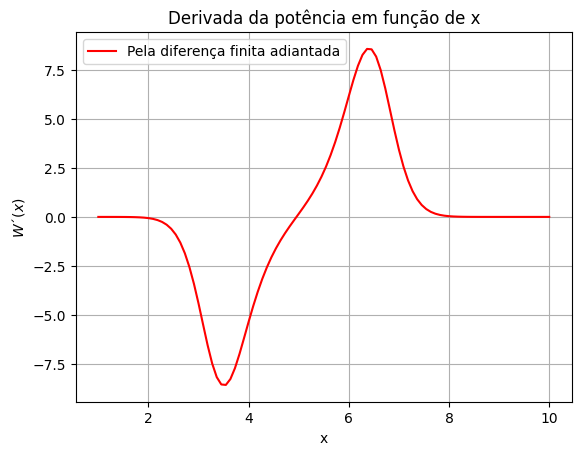

In [210]:
plt.plot(x,deriv_pont_ffd,'-r')
plt.grid()
plt.legend(['Pela diferença finita adiantada'])
plt.xlabel('x')
plt.ylabel('$W´(x)$')
plt.title('Derivada da potência em função de x')
plt.show()

*b)Plot para diferença finita atrasada*

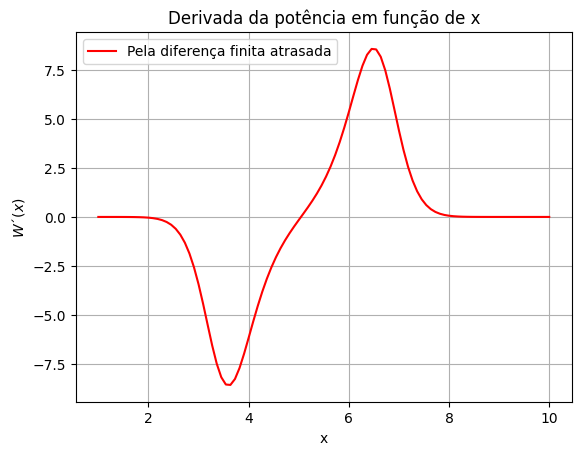

In [211]:
plt.plot(x,deriv_pont_bfd,'-r')
plt.grid()
plt.legend(['Pela diferença finita atrasada'])
plt.xlabel('x')
plt.ylabel('$W´(x)$')
plt.title('Derivada da potência em função de x')
plt.show()

*c)Plot para diferença finita centrada*

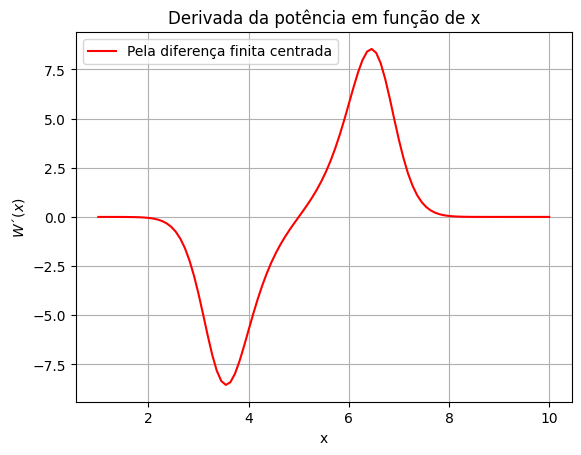

In [212]:
plt.plot(x,deriv_pont_cfd,'-r')
plt.grid()
plt.legend(['Pela diferença finita centrada'])
plt.xlabel('x')
plt.ylabel('$W´(x)$')
plt.title('Derivada da potência em função de x')
plt.show()